## Load Libraries

In [1]:
import os
import cv2
import math
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import skimage.measure
import matplotlib.pyplot as plt

from glob import glob
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import greycomatrix, greycoprops
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, accuracy_score
%matplotlib inline

## Display Image

In [2]:
def display(img):
    plt.imshow (img, interpolation = 'nearest')
    _ = plt.axis(False)

## Load Model

In [3]:
model_path = "Models\\\\"
filename_arr = ["random_forest", "svm","knn"]

In [4]:
model_arr = [pickle.load(open(f"{model_path}{filename}_model.sav", 'rb')) for filename in filename_arr]

rf_model = model_arr[0]
svm_model = model_arr[1]
knn_model = model_arr[2]

## Test Image

### Remove White Background (Threshold)

In [5]:
def remove_background(img, threshold):
    """
    This method removes background from your image
    
    :param img: cv2 image
    :type img: np.array
    :param threshold: threshold value for cv2.threshold
    :type threshold: float
    :return: RGBA image
    :rtype: np.ndarray
    """
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshed = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
    
    cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    mask = cv2.drawContours(threshed, cnt, 0, (0, 255, 0), 0)
    masked_data = cv2.bitwise_and(img, img, mask=mask)

    x, y, w, h = cv2.boundingRect(cnt)
    dst = masked_data[y: y + h, x: x + w]

    dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(dst_gray, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(dst)

    rgba = [r, g, b, alpha]
    dst = cv2.merge(rgba, 4)
    
    dst = cv2.cvtColor(dst, cv2.COLOR_BGRA2RGB)

    return dst

### Conversion Function

#### Convert Val To RGB

In [6]:
def convert_val_to_rgb(x):
    if x >= 0 and x < 64:
        return "00"
    elif x >= 64 and x < 128:
        return "55"
    elif x >= 128 and x < 192:
        return "AA"
    else:
        return "FF"

#### Convert Val To Bin

In [7]:
def convert_val_to_bin(x):
    if x >= 0 and x < 64:
        return 0
    elif x >= 64 and x < 128:
        return 85
    elif x >= 128 and x < 192:
        return 170
    else:
        return 255

### Pipeline Color Features

In [8]:
def pipeline_color(cv_img):
    img_arr = np.array(cv_img)
    img_flatten = img_arr.reshape(1, -1).T
    img_squeeze = np.squeeze(img_flatten)
    img_convert = np.vectorize(convert_val_to_rgb)(img_squeeze)
    img_2d_arr = img_convert.reshape(-1, 3)
    img_list_arr = img_2d_arr.tolist()
    convert_to_str = lambda x:"#"+"".join(list(map(str, x)))
    img_str_arr = [convert_to_str(x) for x in img_list_arr]
    new_arr = np.array(img_str_arr)
    tmp_dict = {a:b for (a,b) in zip(np.unique(new_arr, return_counts=True)[0], np.unique(new_arr, return_counts=True)[1])}
    return tmp_dict

### Pipeline Texture Features

In [9]:
def pipeline_texture(img_gray):
    tmp_dict = {}
    tmp_dict["Mean"] = np.mean(img_gray)
    tmp_dict["Variance"] = np.var(img_gray)
    tmp_dict["Entropy"] = skimage.measure.shannon_entropy(img_gray)
    glcm = greycomatrix(img_gray, [2], [0], 256, symmetric = True, normed = True)
    tmp_dict["Contrast"] = greycoprops(glcm, prop="contrast").item()
    tmp_dict["Homogeneity"] = greycoprops(glcm, prop="homogeneity").item()
    tmp_dict["Correlation"] = greycoprops(glcm, prop="correlation").item()
    tmp_dict["Energy"] = greycoprops(glcm, prop="energy").item()
    return tmp_dict

### Pipeline Shape Features

In [10]:
def pipeline_shape(img_gray):
    # Apply Gaussian Blur to Image
    img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)

    # Canny Edge Detection
    img_canny = cv2.Canny(img_blur, 50, 150)

    # Edge Detector
    kernel = np.ones((5, 5), dtype = np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations = 2)

    contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area, peri = 0, 0
    mu, huMoments = [], []
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        peri = cv2.arcLength(cnt, True)
        mu = cv2.moments(cnt)
        huMoments = cv2.HuMoments(mu)
        
    for i in range(0,7):
        huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]) if abs(huMoments[i]) > 0 else 1)
    
    tmp_dict = {}
    tmp_dict["Area"] = area
    tmp_dict["Perimeter"] = peri
    for (i, huMoment) in enumerate(huMoments):
        tmp_dict[f"huMoment {(i + 1)}"] = huMoment[0]
    return tmp_dict

### Pipeline Final

In [11]:
def pipeline_img(img_path, threshold = 225, h = 100, w = 100):
    cv_img = cv2.imread(img_path)
    
    # Resize Image
    cv_img = cv2.resize(cv_img, (w,h),interpolation = cv2.INTER_AREA)
    
    # Remove White Background
    cv_img = remove_background(cv_img, threshold)
    
    # Convert Image from RGB to BGR
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    
    # Transform CV Image from unint8 to float32
    img_tmp = cv_img / 255.0
    
    # Color Enhancement - Enhance the R, G, B Colors of the image
    r, g, b = cv2.split(img_tmp)
    img_sum = r + g + b
    CR, CG, CB = cv2.divide(r, img_sum), cv2.divide(g, img_sum), cv2.divide(b, img_sum)
    img_tmp = cv2.merge((CR, CG, CB))
    
    # Convert the image from float32 to uint8
    img_tmp = np.uint8(img_tmp * 255)
    
    # Convert the image to Gray Image
    img_gray = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian Blur to Image
    img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)
    
    # Canny Edge Detection
    img_canny = cv2.Canny(img_blur, 50, 150)
    
    # Edge Detector
    kernel = np.ones((5, 5), dtype = np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations = 1)
    
    contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Crop the Image
    roi = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        roi = cv_img[y: y + h, x: x + w]
        
    # Darken Image
    roi = cv2.convertScaleAbs(roi, alpha=0.75, beta=20)
    return roi

In [12]:
def pipeline_all_dict(cv_img):
    final_dict = {}
    
    # Get Color Features
    color_feature_dict = pipeline_color(cv_img)
    final_dict.update(color_feature_dict)
    
    # Convert Image to Gray Image
    img_gray = cv2.cvtColor(cv_img, cv2.COLOR_RGB2GRAY)

    # Get Texture Features
    texture_feature_dict = pipeline_texture(img_gray)
    final_dict.update(texture_feature_dict)

    # Get Shape Features
    shape_feature_dict = pipeline_shape(img_gray)
    final_dict.update(shape_feature_dict)
    
    return final_dict

In [13]:
def pipeline_final(img_path):
    cv_img = pipeline_img(img_path)
    final_dict = pipeline_all_dict(cv_img)
    return final_dict

In [14]:
feature_arr = []

cc = ["00", "55", "AA", "FF"]

# Color Features
for i in cc:
    for j in cc:
        for k in cc:
            feature_arr.append(f"#{i}{j}{k}")

# Texture Feature
feature_arr += ["Mean", "Variance", "Entropy", "Contrast", "Homogeneity", "Correlation", "Energy"]

# Shape Feature
feature_arr += [f"huMoment {(i + 1)}" for i in range(7)]
feature_arr += ["Area", "Perimeter"]

## List All Folders

In [15]:
image_folders = glob('Test_Images/*/')

## List all Files

In [16]:
for folder_path in image_folders:
    folder_name = folder_path.split("\\")[1]
    all_image_in_folder = glob(folder_path + "*.jpg")

## Verify Model Function

In [17]:
def test_model(model, feature_arr, test_folder = "Test_Images"):
    total, correct = 0, 0
    image_folders = glob(f'{test_folder}/*/')
    for folder_path in image_folders:
        final_df = pd.DataFrame(columns = feature_arr)
        fruit_name = folder_path.split("\\")[1]
        all_image_in_folder = glob(folder_path + "*.jpg")
        for img_path in all_image_in_folder:
            final_dict = pipeline_final(img_path)
            final_df = final_df.append(final_dict, ignore_index = True)
        final_df.fillna(0, inplace=True)
        pred_label = model.predict(final_df)
        for (pred_fruit_name, img_path) in zip(pred_label, all_image_in_folder):
            img_name = img_path.split("\\")[-1]
            total += 1
            correct += 1 if pred_fruit_name == fruit_name else 0
            print(f"Success! {img_name} is {pred_fruit_name}!" if pred_fruit_name == fruit_name else f"Error... {img_name} is not {pred_fruit_name}...")
    
    print(f"\nFinal Result: {correct} / {total}\nPercentage: {(correct / total) * 100.0}%")

In [18]:
test_model(rf_model, feature_arr)

Success! apple1.jpg is Apple!
Success! apple2.jpg is Apple!
Success! apple3.jpg is Apple!
Error... apple4.jpg is not Lychee...
Success! grape.jpg is Grape!
Success! grape2.jpg is Grape!
Success! grape3.jpg is Grape!
Success! grape4.jpg is Grape!
Success! lemon1.jpg is Lemon!
Success! lemon2.jpg is Lemon!
Error... lemon3.jpg is not Limes...
Success! lemon4.jpg is Lemon!
Success! lime.jpg is Limes!
Success! Limes1.jpg is Limes!
Success! Limes2.jpg is Limes!
Success! Limes3.jpg is Limes!
Success! Lychee1.jpg is Lychee!
Success! Lychee2.jpg is Lychee!
Success! Lychee3.jpg is Lychee!
Error... lychee4.jpg is not Apple...
Error... pear1.jpg is not Lemon...
Error... pear2.jpg is not Lemon...
Success! pear3.jpg is Pear!
Error... Pear4.jpg is not Lemon...

Final Result: 18 / 24
Percentage: 75.0%


## Visualize and Make Prediction

In [19]:
def plot_img_grid(img_arr, nb_rows, nb_cols, figsize=(5, 5)):
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].imshow(img_arr[n], interpolation = 'nearest')
            axs[i, j].axis('off')
            n += 1  

In [20]:
def get_result_score(model, feature_arr, test_folder = "Test_Images"):
    total, correct = 0, 0
    image_folders = glob(f'{test_folder}/*/')
    
    for folder_path in image_folders:
        final_df = pd.DataFrame(columns = feature_arr)
        fruit_name = folder_path.split("\\")[1]
        all_image_in_folder = glob(folder_path + "*.jpg")
        
        for img_path in all_image_in_folder:
            final_dict = pipeline_final(img_path)
            final_df = final_df.append(final_dict, ignore_index = True)
        
        final_df.fillna(0, inplace=True)
        pred_label = model.predict(final_df)
        
        for pred_fruit_name in pred_label:
            total += 1
            correct += 1 if pred_fruit_name == fruit_name else 0
        
    print(f"\nFinal Result: {correct} / {total}\nPercentage: {(correct / total) * 100.0}%")

In [21]:
def get_pred_df(model, feature_arr, test_folder = "Test_Images"):
    image_folders = glob(f'{test_folder}/*/')
    pred_dict = {}
    
    for folder_path in image_folders:
        final_df = pd.DataFrame(columns = feature_arr)
        fruit_name = folder_path.split("\\")[1]
        all_image_in_folder = glob(folder_path + "*.jpg")
        
        for img_path in all_image_in_folder:
            final_dict = pipeline_final(img_path)
            final_df = final_df.append(final_dict, ignore_index = True)
        
        final_df.fillna(0, inplace=True)
        pred_label = model.predict(final_df)
        tmp_fruit_arr = [pred_fruit_name for pred_fruit_name in pred_label]
        pred_dict[fruit_name] = tmp_fruit_arr
    
    pred_df = pd.DataFrame(pred_dict).T
    pred_df = pred_df.rename(columns = {ind:f"Image {ind + 1}" for ind in range(4)})
    
    return pred_df

In [22]:
def convert_img_path_to_cv_img(img_path, threshold = 225, ht = 100, wt = 100):
    cv_img = cv2.imread(img_path)
    
    # Resize Image
    cv_img = cv2.resize(cv_img, (wt,ht),interpolation = cv2.INTER_AREA)
    
    # Remove White Background
    cv_img = remove_background(cv_img, threshold)
    
    # Convert Image from RGB to BGR
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    
    # Transform CV Image from unint8 to float32
    img_tmp = cv_img / 255.0
    
    # Color Enhancement - Enhance the R, G, B Colors of the image
    r, g, b = cv2.split(img_tmp)
    img_sum = r + g + b
    CR, CG, CB = cv2.divide(r, img_sum), cv2.divide(g, img_sum), cv2.divide(b, img_sum)
    img_tmp = cv2.merge((CR, CG, CB))
    
    # Convert the image from float32 to uint8
    img_tmp = np.uint8(img_tmp * 255)
    
    # Convert the image to Gray Image
    img_gray = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian Blur to Image
    img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)
    
    # Canny Edge Detection
    img_canny = cv2.Canny(img_blur, 50, 150)
    
    # Edge Detector
    kernel = np.ones((5, 5), dtype = np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations = 1)
    
    contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Crop the Image
    roi = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        roi = cv_img[y: y + h, x: x + w]
        
    # Darken Image
    roi = cv2.convertScaleAbs(roi, alpha=0.75, beta=20)
    return roi

In [23]:
def get_img_arr(test_folder = "Test_Images"):
    image_folders = glob(f'{test_folder}/*/')
    img_arr = []
    
    for folder_path in image_folders:
        final_df = pd.DataFrame(columns = feature_arr)
        fruit_name = folder_path.split("\\")[1]
        all_image_in_folder = glob(folder_path + "*.jpg")
        
        for img_path in all_image_in_folder:
            img_arr.append(convert_img_path_to_cv_img(img_path))
    return img_arr

## Test Individual Image

In [24]:
# test_ind_img_path = "Test_Images\\Lemon\\lemon1.jpg"
test_ind_img_path = "Dataset\\Apple\\0_100.jpg"

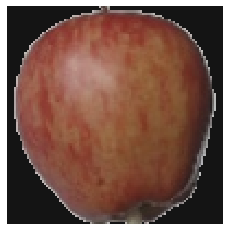

In [25]:
tmp_img = convert_img_path_to_cv_img(test_ind_img_path)
display(tmp_img)

## Test Image Folder

In [26]:
test_img_path = "Test_Images"

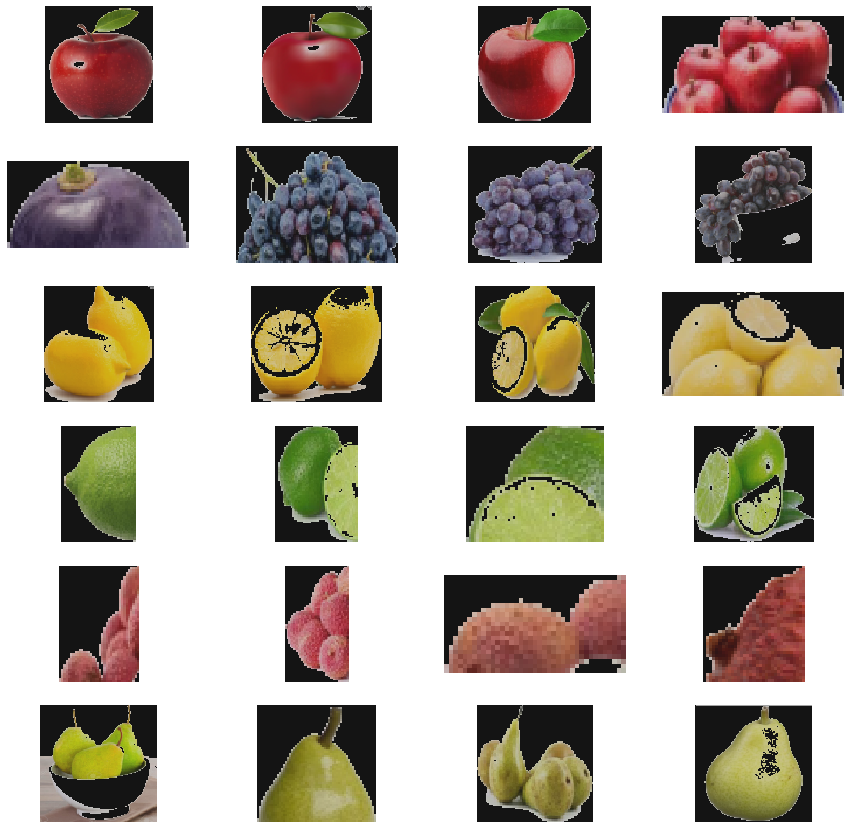

In [27]:
plot_img_grid(get_img_arr(test_img_path), 6, 4, (15, 15))

In [28]:
print("Prediction: ")
get_pred_df(rf_model, feature_arr, test_img_path)

Prediction: 


,Image 1,Image 2,Image 3,Image 4
Apple,Apple,Apple,Apple,Lychee
Grape,Grape,Grape,Grape,Grape
Lemon,Lemon,Lemon,Limes,Lemon
Limes,Limes,Limes,Limes,Limes
Lychee,Lychee,Lychee,Lychee,Apple
Pear,Lemon,Lemon,Pear,Lemon


In [29]:
get_result_score(rf_model, feature_arr, test_img_path)


Final Result: 18 / 24
Percentage: 75.0%


## Sample Image Folder

In [30]:
test_img_path = "Sample"

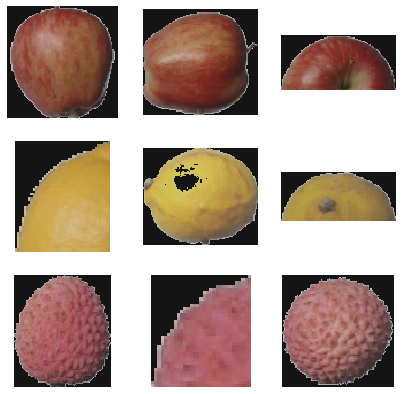

In [31]:
plot_img_grid(get_img_arr(test_img_path), 3, 3, (7, 7))

In [32]:
print("Prediction: ")
get_pred_df(rf_model, feature_arr, test_img_path)

Prediction: 


,Image 1,Image 2,Image 3
Apple,Apple,Apple,Apple
Lemon,Lemon,Lemon,Lemon
Lychee,Lychee,Lychee,Lychee


In [33]:
get_result_score(rf_model, feature_arr, test_img_path)


Final Result: 9 / 9
Percentage: 100.0%
